# Weather Dataset Processing and Classification

This notebook implements a weather classification system using sky images and weather data. It includes:

1. Loading and preprocessing weather data from JSON files and images
2. K-means clustering for automatic weather classification
3. Feature engineering for enhanced classification
4. Dataset management for machine learning
5. Analysis and visualization of weather patterns

The system uses cloud coverage, sun obscuration, and irradiance measurements to classify weather conditions into distinct categories.

## 1. Required Imports and Setup

First, let's import all the required libraries. For Google Colab, we might need to install some packages first.

In [1]:
# !pip uninstall numpy scipy matplotlib opencv-python-headless -y

# !pip install scipy==1.10.1
# !pip install scikit-learn==1.2.2
# !pip install opencv-python-headless
# !pip install matplotlib
# !pip install numpy==1.26.4 --force
# !pip install pandas==1.5.3
# !pip install seaborn


# Import required libraries
import os
import glob
import json
import numpy as np
import cv2
import pandas as pd
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# --- Clustering and Silhouette Score Evaluation ---
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Example: Load your weather data into a DataFrame
df = pd.DataFrame(weather_data)  # weather_data should be a list of dicts with features
features = ['cloud_coverage', 'sun_obscuration_percentage', 'irradiance']
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
n_clusters = 4  # Change as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df['cluster'] = cluster_labels

# Evaluate clustering with Silhouette Score
score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for {n_clusters} clusters: {score:.4f}")

# Perform K-means clustering
n_clusters = 5  # Change as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df['cluster'] = cluster_labels

# Evaluate clustering with Silhouette Score
score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for {n_clusters} clusters: {score:.4f}")

# Perform K-means clustering
n_clusters = 6  # Change as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df['cluster'] = cluster_labels

# Evaluate clustering with Silhouette Score
score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for {n_clusters} clusters: {score:.4f}")

Silhouette Score for 4 clusters: 0.5141
Silhouette Score for 5 clusters: 0.5025
Silhouette Score for 6 clusters: 0.4989


In [1]:
# --- Load Weather Data for Clustering ---
import glob
import json

weather_data = []
json_dir = r"D:\Image\test_result\json"  # Update this path if needed
json_files = glob.glob(json_dir + "/**/*.json", recursive=True)
print(f"Found {len(json_files)} JSON files")

for json_file in json_files:
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    try:
                        entry = json.loads(line)
                        # Only add if required fields exist
                        if entry.get('cloud_coverage') is not None:
                            weather_data.append({
                                'cloud_coverage': entry.get('cloud_coverage', 0.0),
                                'sun_obscuration_percentage': entry.get('sun_obscuration_percentage', 0.0),
                                'irradiance': entry.get('irradiance', 0.0),
                                'timestamp': entry.get('now', '')
                            })
                    except json.JSONDecodeError:
                        continue
    except Exception as e:
        print(f"Error reading {json_file}: {e}")

print(f"Loaded {len(weather_data)} weather data entries.")

Found 80 JSON files
Loaded 93988 weather data entries.


## 2. Data Loading Functions

Let's define the functions needed to load and process weather data from JSON files and images. The main function `load_weather_data_with_clustering` will:
1. Load weather data from JSON files
2. Extract relevant features
3. Perform K-means clustering
4. Load and preprocess corresponding images
5. Create labels based on cluster assignments

In [2]:
def load_weather_data_with_clustering(json_dir, image_dir, image_size=128, n_clusters=5):
    """
    Load weather data from JSON files and perform K-means clustering for weather classification.
    
    Args:
        json_dir: Directory containing JSON files with weather data
        image_dir: Directory containing the actual images
        image_size: Size to resize images to
        n_clusters: Number of clusters for K-means
    
    Returns:
        images, labels, ids, cls, metadata, kmeans_model
    """
    images = []
    labels = []
    ids = []
    cls = []
    metadata = []
    
    print('Stage 1/4: Reading weather data from JSON files...')
    
    # Find all JSON files recursively
    json_files = glob.glob(os.path.join(json_dir, "**/*.json"), recursive=True)
    print(f'Found {len(json_files)} JSON files')
    
    # First pass: collect all weather data for clustering
    weather_data = []
    total_entries = 0
    
    for i, json_file in enumerate(json_files, 1):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.strip():
                        try:
                            entry = json.loads(line)
                            total_entries += 1
                            
                            # Extract required fields
                            image_path = entry.get('image_path', '')
                            cloud_coverage = entry.get('cloud_coverage', 0.0)
                            irradiance = entry.get('irradiance', 0.0)
                            sun_obscuration_percentage = entry.get('sun_obscuration_percentage', 0.0)
                            timestamp = entry.get('now', '')
                            
                            # Skip entries without required data
                            if not image_path or cloud_coverage is None:
                                continue
                            
                            # Store data for clustering
                            weather_data.append({
                                'image_path': image_path,
                                'cloud_coverage': cloud_coverage,
                                'sun_obscuration_percentage': sun_obscuration_percentage,
                                'irradiance': irradiance,
                                'timestamp': timestamp
                            })
                            
                        except json.JSONDecodeError as e:
                            print(f"Error decoding JSON in {json_file}: {e}")
                            continue
                            
        except Exception as e:
            print(f"Error reading file {json_file}: {e}")
            continue
        
        if i % 10 == 0:  # Show progress every 10 files
            print(f'Processed {i}/{len(json_files)} files, found {len(weather_data)} valid entries')
    
    if not weather_data:
        raise ValueError("No valid data found!")
    
    print(f'\nStage 2/4: Performing K-means clustering with {n_clusters} clusters...')
    df = pd.DataFrame(weather_data)
    
    # Prepare features for clustering
    features = ['cloud_coverage', 'sun_obscuration_percentage', 'irradiance']
    X = df[features]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster assignments to dataframe
    df['cluster'] = cluster_labels
    
    print(f'Clustering completed. Cluster distribution: {np.bincount(cluster_labels)}')
    
    print('\nStage 3/4: Loading and preprocessing images...')
    # Second pass: load images and create labels
    total = len(df)
    processed = 0
    skipped = 0
    
    for idx, row in df.iterrows():
        processed += 1
        if processed % 100 == 0:  # Show progress every 100 images
            print(f'Processing images: {processed}/{total} ({skipped} skipped)')
            
        # Construct full image path
        full_image_path = os.path.join(image_dir, os.path.basename(row['image_path']))
        
        # Check if image exists
        if not os.path.exists(full_image_path):
            skipped += 1
            continue
        
        # Load and preprocess image
        image = cv2.imread(full_image_path)
        if image is None:
            skipped += 1
            continue
            
        image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get cluster assignment as weather class
        weather_class = int(row['cluster'])
        
        # Create one-hot encoded label
        label = np.zeros(n_clusters)
        label[weather_class] = 1.0
        
        images.append(image)
        labels.append(label)
        ids.append(os.path.basename(row['image_path']))
        cls.append(weather_class)
        
        # Store metadata for analysis
        metadata.append({
            'image_path': row['image_path'],
            'cloud_coverage': row['cloud_coverage'],
            'irradiance': row['irradiance'],
            'sun_obscuration_percentage': row['sun_obscuration_percentage'],
            'timestamp': row['timestamp'],
            'weather_class': weather_class
        })
    
    print('\nStage 4/4: Finalizing dataset...')
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)
    
    print(f'\nDataset creation complete:')
    print(f'- Total entries processed: {total_entries}')
    print(f'- Valid entries found: {len(weather_data)}')
    print(f'- Images loaded: {len(images)}')
    print(f'- Images skipped: {skipped}')
    print(f'Weather class distribution: {np.bincount(cls)}')
    
    return images, labels, ids, cls, metadata, kmeans

## 3. WeatherDataSet Class

The `WeatherDataSet` class manages the dataset for training and validation. It provides:
- Data normalization
- Batch generation
- Access to images, labels, and additional features
- Tracking of epochs and training progress

In [3]:
class WeatherDataSet(object):
    """Dataset class for weather classification with additional features."""
    
    def __init__(self, images, labels, ids, cls, features=None):
        self._num_examples = images.shape[0]
        
        # Normalize images
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)
        
        self._images = images
        self._labels = labels
        self._ids = ids
        self._cls = cls
        self._features = features
        self._epochs_completed = 0
        self._index_in_epoch = 0
    
    @property
    def images(self):
        return self._images
    
    @property
    def labels(self):
        return self._labels
    
    @property
    def ids(self):
        return self._ids
    
    @property
    def cls(self):
        return self._cls
    
    @property
    def features(self):
        return self._features
    
    @property
    def num_examples(self):
        return self._num_examples
    
    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    def next_batch(self, batch_size):
        """Return the next batch of examples."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        
        end = self._index_in_epoch
        
        batch_images = self._images[start:end]
        batch_labels = self._labels[start:end]
        batch_ids = self._ids[start:end]
        batch_cls = self._cls[start:end]
        
        if self._features is not None:
            batch_features = self._features[start:end]
            return batch_images, batch_labels, batch_ids, batch_cls, batch_features
        else:
            return batch_images, batch_labels, batch_ids, batch_cls

## 4. Feature Engineering

To enhance the classification, we create additional features from the metadata:
- Time-based features (hour, month) converted to cyclical representation
- Normalized weather measurements
- Combined feature vectors for advanced models

In [4]:
def create_weather_features(metadata):
    """
    Create additional features from metadata for enhanced classification.
    
    Args:
        metadata: List of dictionaries containing weather data
    
    Returns:
        features: numpy array of additional features
    """
    features = []
    
    for entry in metadata:
        # Extract time-based features
        timestamp = entry['timestamp']
        try:
            dt = datetime.strptime(timestamp, '%Y%m%d_%H%M%S')
            hour = dt.hour
            month = dt.month
            # Create cyclical time features
            hour_sin = np.sin(2 * np.pi * hour / 24)
            hour_cos = np.cos(2 * np.pi * hour / 24)
            month_sin = np.sin(2 * np.pi * month / 12)
            month_cos = np.cos(2 * np.pi * month / 12)
        except:
            hour_sin = hour_cos = month_sin = month_cos = 0
        
        # Combine all features
        feature_vector = [
            entry['cloud_coverage'],
            entry['sun_obscuration_percentage'],
            entry['irradiance'] / 1000.0,  # Normalize irradiance
            hour_sin,
            hour_cos,
            month_sin,
            month_cos
        ]
        
        features.append(feature_vector)
    
    return np.array(features)

## 5. Cluster Analysis and Weather Classification

After clustering the weather data, we analyze the characteristics of each cluster to assign meaningful weather descriptions. The analysis is based on:
- Cloud coverage
- Sun obscuration
- Irradiance levels
- Time patterns

# Fixed Weather Classification

We'll classify weather into 5 fixed categories based on cloud coverage and irradiance:

1. Clear Sky (Low cloud coverage, high irradiance)
2. Partly Cloudy (Medium cloud coverage, medium-high irradiance)
3. Cloudy (High cloud coverage, medium irradiance)
4. Overcast (Very high cloud coverage, low irradiance)
5. Night/Low Light (Any cloud coverage, very low irradiance)

This classification is based on fixed thresholds rather than clustering.

In [5]:
def get_weather_class(cloud_coverage, irradiance, sun_obscuration=None):
    """
    Determine weather class based on fixed thresholds.
    Returns class index (0-4) and class name.
    """
    # Night/Low Light conditions
    if irradiance < 10:  # Very low irradiance
        return 4, "Night/Low Light"
    
    # Daytime conditions
    if cloud_coverage < 0.3:  # Clear sky
        if irradiance > 600:
            return 0, "Clear Sky"
        else:
            return 4, "Night/Low Light"  # Early morning/late evening
    elif cloud_coverage < 0.5:  # Partly cloudy
        return 1, "Partly Cloudy"
    elif cloud_coverage < 0.7:  # Cloudy
        return 2, "Cloudy"
    else:  # Overcast
        return 3, "Overcast"

def get_fixed_weather_classes(metadata):
    """
    Classify weather conditions into fixed categories without clustering.
    """
    weather_classes = []
    class_counts = {i: 0 for i in range(5)}
    
    for entry in metadata:
        class_idx, class_name = get_weather_class(
            entry['cloud_coverage'],
            entry['irradiance'],
            entry.get('sun_obscuration_percentage', 0)
        )
        weather_classes.append({
            'weather_class': class_idx,
            'class_name': class_name,
            **entry
        })
        class_counts[class_idx] += 1
    
    print("\nWeather Class Distribution:")
    print("=" * 50)
    for idx, count in sorted(class_counts.items()):
        name = get_weather_class(0, 1000)[1] if idx == 0 else \
               get_weather_class(0.4, 500)[1] if idx == 1 else \
               get_weather_class(0.6, 400)[1] if idx == 2 else \
               get_weather_class(0.8, 300)[1] if idx == 3 else \
               get_weather_class(0, 5)[1]
        print(f"Class {idx} ({name}): {count} samples")
    
    return weather_classes

def analyze_fixed_weather_classes(metadata):
    """
    Analyze and visualize fixed weather classifications
    """
    df = pd.DataFrame(metadata)
    
    # Create scatter plots
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Weather Classification Analysis', fontsize=16)
    
    # Plot 1: Cloud Coverage vs Irradiance
    scatter1 = axs[0, 0].scatter(df['cloud_coverage'], df['irradiance'], 
                                c=df['weather_class'], cmap='viridis')
    axs[0, 0].set_title('Cloud Coverage vs Irradiance')
    axs[0, 0].set_xlabel('Cloud Coverage')
    axs[0, 0].set_ylabel('Irradiance (W/m²)')
    plt.colorbar(scatter1, ax=axs[0, 0], label='Weather Class')
    
    # Add decision boundaries for visualization
    x = np.linspace(0, 1, 100)
    y_clear = np.ones_like(x) * 600
    y_low = np.ones_like(x) * 10
    axs[0, 0].plot(x, y_clear, 'r--', alpha=0.5)
    axs[0, 0].plot(x, y_low, 'r--', alpha=0.5)
    axs[0, 0].axvline(x=0.3, color='r', linestyle='--', alpha=0.5)
    axs[0, 0].axvline(x=0.5, color='r', linestyle='--', alpha=0.5)
    axs[0, 0].axvline(x=0.7, color='r', linestyle='--', alpha=0.5)
    
    # Plot 2: Class distribution
    class_counts = df['weather_class'].value_counts().sort_index()
    axs[0, 1].bar(class_counts.index, class_counts.values)
    axs[0, 1].set_title('Weather Class Distribution')
    axs[0, 1].set_xlabel('Weather Class')
    axs[0, 1].set_ylabel('Number of Samples')
    
    # Plot 3: Time series of weather classes
    df['datetime'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H%M%S')
    axs[1, 0].scatter(df['datetime'], df['weather_class'], c=df['weather_class'], cmap='viridis')
    axs[1, 0].set_title('Weather Classes Over Time')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Weather Class')
    
    # Plot 4: Average characteristics by class
    class_stats = df.groupby('weather_class').agg({
        'cloud_coverage': 'mean',
        'irradiance': 'mean',
        'sun_obscuration_percentage': 'mean'
    }).reset_index()
    
    x = np.arange(len(class_stats))
    width = 0.25
    
    axs[1, 1].bar(x - width, class_stats['cloud_coverage'], width, label='Cloud Coverage')
    axs[1, 1].bar(x, class_stats['irradiance']/1000, width, label='Irradiance (kW/m²)')
    axs[1, 1].bar(x + width, class_stats['sun_obscuration_percentage'], width, label='Sun Obscuration')
    
    axs[1, 1].set_title('Average Characteristics by Class')
    axs[1, 1].set_xlabel('Weather Class')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].set_xticks(x)
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
def get_cluster_characteristics(metadata, kmeans_model):
    """
    Analyze the characteristics of each cluster to provide meaningful weather descriptions.
    Based on actual findings from previous study.
    """
    df = pd.DataFrame(metadata)
    
    # Ensure we have the cluster information
    if 'cluster' not in df and 'weather_class' not in df:
        raise ValueError("Metadata must contain either 'cluster' or 'weather_class' field")
    
    # Use 'cluster' field, fallback to 'weather_class' if needed
    cluster_field = 'cluster' if 'cluster' in df else 'weather_class'
    
    cluster_descriptions = {}
    
    for cluster in sorted(df[cluster_field].unique()):
        cluster_data = df[df[cluster_field] == cluster]
        
        avg_cloud = cluster_data['cloud_coverage'].mean()
        avg_irradiance = cluster_data['irradiance'].mean()
        avg_sun_obscuration = cluster_data['sun_obscuration_percentage'].mean()
        
        # Create description based on actual cluster characteristics
        if avg_cloud > 0.7 and avg_sun_obscuration > 0.6 and avg_irradiance < 400:
            desc = f"Heavily Overcast (Cluster {cluster})"
        elif avg_cloud > 0.4 and avg_cloud < 0.7 and avg_irradiance > 400 and avg_irradiance < 700:
            desc = f"Partially Cloudy (Cluster {cluster})"
        elif avg_cloud > 0.3 and avg_cloud < 0.6 and avg_irradiance > 700:
            desc = f"Partly Cloudy with Strong Sunlight (Cluster {cluster})"
        elif avg_cloud < 0.3 and avg_irradiance < 500:
            desc = f"Mostly Clear under Low Sun (Cluster {cluster})"
        elif avg_cloud < 0.2 and avg_irradiance > 800:
            desc = f"Bright Clear Sky (Cluster {cluster})"
        else:
            # Fallback description
            if avg_cloud < 0.3:
                if avg_irradiance > 700:
                    desc = f"Clear Sky (Cluster {cluster})"
                else:
                    desc = f"Clear Sky Low Sun (Cluster {cluster})"
            elif avg_cloud < 0.6:
                if avg_irradiance > 600:
                    desc = f"Partly Cloudy (Cluster {cluster})"
                else:
                    desc = f"Cloudy (Cluster {cluster})"
            else:
                desc = f"Overcast (Cluster {cluster})"
        
        cluster_descriptions[cluster] = {
            'description': desc,
            'avg_cloud_coverage': avg_cloud,
            'avg_irradiance': avg_irradiance,
            'avg_sun_obscuration_percentage': avg_sun_obscuration,
            'count': len(cluster_data)
        }
    
    return cluster_descriptions

## 6. Dataset Creation and Splitting

Finally, let's implement the functions to create train and validation datasets. This includes:
- Loading all weather data and images
- Applying clustering
- Creating additional features
- Splitting data into training and validation sets
- Creating `WeatherDataSet` objects

In [7]:
def read_weather_sets_with_clustering(json_dir, image_dir, image_size=128, validation_size=0.2, use_features=True, n_clusters=5):
    """
    Read weather datasets using K-means clustering for classification.
    """
    class DataSets(object):
        pass
    
    data_sets = DataSets()
    
    # Load all data with clustering
    print("Loading and clustering weather data...")
    images, labels, ids, cls, metadata, kmeans_model = load_weather_data_with_clustering(
        json_dir, image_dir, image_size, n_clusters
    )
    
    # Get cluster characteristics
    cluster_descriptions = get_cluster_characteristics(metadata, kmeans_model)
    
    # Create additional features if requested
    features = None
    if use_features:
        print("Creating additional features...")
        features = create_weather_features(metadata)
        # Normalize features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    
    # Shuffle data
    print("Shuffling and splitting data...")
    if features is not None:
        images, labels, ids, cls, features = shuffle(images, labels, ids, cls, features)
    else:
        images, labels, ids, cls = shuffle(images, labels, ids, cls)
    
    # Split into train and validation
    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])
    
    # Split indices
    indices = np.arange(len(images))
    train_indices, val_indices = train_test_split(
        indices, test_size=validation_size, stratify=cls, random_state=42
    )
    
    # Create training set
    train_images = images[train_indices]
    train_labels = labels[train_indices]
    train_ids = ids[train_indices]
    train_cls = cls[train_indices]
    train_features = features[train_indices] if features is not None else None
    
    # Create validation set
    val_images = images[val_indices]
    val_labels = labels[val_indices]
    val_ids = ids[val_indices]
    val_cls = cls[val_indices]
    val_features = features[val_indices] if features is not None else None
    
    print("\nDataset creation complete:")
    print(f"Training samples: {len(train_images)}")
    print(f"Validation samples: {len(val_images)}")
    
    data_sets.train = WeatherDataSet(train_images, train_labels, train_ids, train_cls, train_features)
    data_sets.valid = WeatherDataSet(val_images, val_labels, val_ids, val_cls, val_features)
    data_sets.cluster_descriptions = cluster_descriptions
    data_sets.kmeans_model = kmeans_model
    data_sets.metadata = metadata
    
    return data_sets

## 7. Example Usage

Here's an example of how to use the weather dataset functions. Replace the paths with your actual data paths when running in Google Colab:

1. Mount your Google Drive (if using Colab)
2. Load and process the weather data
3. Analyze the cluster characteristics
4. Create train/validation datasets
5. Visualize the results

In [8]:
# Set up directory paths for local use
import os

# Base directory containing images and weather data
base_dir = r"D:\Image"  # Your image directory
test_result_dir = os.path.join(base_dir, "test_result")
json_dir = os.path.join(test_result_dir, "json")

print("Setting up with local paths:")
print(f"Base directory: {base_dir}")
print(f"Test result directory: {test_result_dir}")
print(f"JSON directory: {json_dir}")

# Create directories if they don't exist
print("\nSetting up directory structure...")
os.makedirs(test_result_dir, exist_ok=True)
os.makedirs(json_dir, exist_ok=True)

# Create month subdirectories
print("\nSetting up month subdirectories...")
for month in range(1, 13):
    month_dir = os.path.join(json_dir, f"{month:02d}")
    os.makedirs(month_dir, exist_ok=True)

# Check for image files
print("\nChecking for image files...")
image_files = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

print(f"\nFound {len(image_files)} image files")
if image_files:
    print("Sample images:")
    for file in image_files[:5]:
        print(f"- {os.path.basename(file)}")

# Check for JSON files
print("\nChecking for JSON files...")
json_files = glob.glob(os.path.join(json_dir, "**/*.json"), recursive=True)
print(f"Found {len(json_files)} JSON files")
if json_files:
    print("Sample JSON files:")
    for file in json_files[:5]:
        print(f"- {os.path.relpath(file, json_dir)}")

# Verify we have necessary files
if not image_files:
    raise ValueError(f"No image files found in {base_dir}. Please ensure your images are in this directory.")
if not json_files:
    raise ValueError(f"No JSON files found in {json_dir}. Please run cloud_detection.py first to generate JSON files.")

Setting up with local paths:
Base directory: D:\Image
Test result directory: D:\Image\test_result
JSON directory: D:\Image\test_result\json

Setting up directory structure...

Setting up month subdirectories...

Checking for image files...

Found 280463 image files
Sample images:
- 20250101_002700.jpg
- 20250101_002730.jpg
- 20250101_002800.jpg
- 20250101_002830.jpg
- 20250101_002900.jpg

Checking for JSON files...
Found 80 JSON files
Sample JSON files:
- 01\01.json
- 01\02.json
- 01\03.json
- 01\04.json
- 01\05.json

Found 280463 image files
Sample images:
- 20250101_002700.jpg
- 20250101_002730.jpg
- 20250101_002800.jpg
- 20250101_002830.jpg
- 20250101_002900.jpg

Checking for JSON files...
Found 80 JSON files
Sample JSON files:
- 01\01.json
- 01\02.json
- 01\03.json
- 01\04.json
- 01\05.json


In [9]:
# Test clustering with sample data
def analyze_weather_clusters(metadata, kmeans_model):
    """Analyze and visualize weather clusters"""
    df = pd.DataFrame(metadata)
    
    # Create scatter plots
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Weather Clustering Analysis', fontsize=16)
    
    # Plot 1: Cloud Coverage vs Irradiance
    scatter1 = axs[0, 0].scatter(df['cloud_coverage'], df['irradiance'], 
                                c=df['weather_class'], cmap='viridis')
    axs[0, 0].set_title('Cloud Coverage vs Irradiance')
    axs[0, 0].set_xlabel('Cloud Coverage')
    axs[0, 0].set_ylabel('Irradiance (W/m²)')
    plt.colorbar(scatter1, ax=axs[0, 0], label='Cluster')
    
    # Plot 2: Sun Obscuration vs Irradiance
    scatter2 = axs[0, 1].scatter(df['sun_obscuration_percentage'], df['irradiance'],
                                c=df['weather_class'], cmap='viridis')
    axs[0, 1].set_title('Sun Obscuration vs Irradiance')
    axs[0, 1].set_xlabel('Sun Obscuration %')
    axs[0, 1].set_ylabel('Irradiance (W/m²)')
    plt.colorbar(scatter2, ax=axs[0, 1], label='Cluster')
    
    # Plot 3: Time series of weather classes
    df['datetime'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H%M%S')
    axs[1, 0].scatter(df['datetime'], df['weather_class'], c=df['weather_class'], cmap='viridis')
    axs[1, 0].set_title('Weather Classes Over Time')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Weather Class')
    
    # Plot 4: Class distribution
    class_counts = df['weather_class'].value_counts().sort_index()
    axs[1, 1].bar(class_counts.index, class_counts.values)
    axs[1, 1].set_title('Weather Class Distribution')
    axs[1, 1].set_xlabel('Weather Class')
    axs[1, 1].set_ylabel('Number of Samples')
    
    plt.tight_layout()
    plt.show()
    
    # Print cluster characteristics
    print("\nCluster Characteristics:")
    print("=" * 80)
    cluster_descriptions = get_cluster_characteristics(metadata, kmeans_model)
    
    for cluster, info in sorted(cluster_descriptions.items()):
        print(f"\nCluster {cluster}:")
        print(f"Description: {info['description']}")
        print(f"Average Cloud Coverage: {info['avg_cloud_coverage']:.3f}")
        print(f"Average Irradiance: {info['avg_irradiance']:.2f} W/m²")
        print(f"Average Sun Obscuration: {info['avg_sun_obscuration_percentage']:.3f}%")
        print(f"Number of samples: {info['count']}")

# Run a test with your data
json_dir = os.path.join(test_result_dir, "json")  # Your JSON directory
image_dir = base_dir  # Your image directory

print("Loading and analyzing weather data...")
images, labels, ids, cls, metadata, kmeans_model = load_weather_data_with_clustering(
    json_dir=json_dir,
    image_dir=image_dir,
    image_size=128,
    n_clusters=5
)

print("\nAnalyzing clustering results...")
analyze_weather_clusters(metadata, kmeans_model)

# Print some sample predictions
print("\nSample Image Classifications:")
print("=" * 80)
for i in range(min(5, len(ids))):
    cluster = cls[i]
    img_id = ids[i]
    cluster_info = get_cluster_characteristics([metadata[i]], kmeans_model)[cluster]
    print(f"\nImage: {img_id}")
    print(f"Assigned Weather Class: {cluster_info['description']}")
    print(f"Cloud Coverage: {metadata[i]['cloud_coverage']:.3f}")
    print(f"Irradiance: {metadata[i]['irradiance']:.2f} W/m²")

Loading and analyzing weather data...
Stage 1/4: Reading weather data from JSON files...
Found 80 JSON files
Processed 10/80 files, found 11595 valid entries
Processed 20/80 files, found 23235 valid entries
Processed 30/80 files, found 34928 valid entries
Processed 40/80 files, found 46691 valid entries
Processed 50/80 files, found 58518 valid entries
Processed 60/80 files, found 70410 valid entries
Processed 70/80 files, found 81998 valid entries
Processed 80/80 files, found 93988 valid entries

Stage 2/4: Performing K-means clustering with 5 clusters...
Clustering completed. Cluster distribution: [36573  8657 14362  9019 25377]

Stage 3/4: Loading and preprocessing images...
Processing images: 100/93988 (0 skipped)
Processing images: 200/93988 (0 skipped)
Processing images: 300/93988 (0 skipped)
Processing images: 400/93988 (0 skipped)
Processing images: 500/93988 (0 skipped)
Processing images: 600/93988 (0 skipped)
Processing images: 700/93988 (0 skipped)
Processing images: 800/9398

KeyboardInterrupt: 

# Test Functions

Here are two separate test functions:
1. `test_clustering_only`: Tests the K-means clustering on weather data without image processing
2. `test_image_processing`: Tests image preprocessing with a small sample

In [10]:
def test_clustering_only(json_dir, n_clusters=5):
    """
    Test only the clustering part without image processing
    Uses fixed number of clusters without descriptive labels
    """
    print('Reading weather data from JSON files...')
    
    # Find all JSON files recursively
    json_files = glob.glob(os.path.join(json_dir, "**/*.json"), recursive=True)
    print(f'Found {len(json_files)} JSON files')
    
    # Collect weather data for clustering
    weather_data = []
    total_entries = 0
    
    for i, json_file in enumerate(json_files, 1):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.strip():
                        try:
                            entry = json.loads(line)
                            total_entries += 1
                            
                            # Extract required fields
                            cloud_coverage = entry.get('cloud_coverage', 0.0)
                            irradiance = entry.get('irradiance', 0.0)
                            sun_obscuration_percentage = entry.get('sun_obscuration_percentage', 0.0)
                            timestamp = entry.get('now', '')
                            
                            # Skip entries without required data
                            if cloud_coverage is None:
                                continue
                            
                            # Store data for clustering
                            weather_data.append({
                                'cloud_coverage': cloud_coverage,
                                'sun_obscuration_percentage': sun_obscuration_percentage,
                                'irradiance': irradiance,
                                'timestamp': timestamp
                            })
                            
                        except json.JSONDecodeError as e:
                            print(f"Error decoding JSON in {json_file}: {e}")
                            continue
                            
        except Exception as e:
            print(f"Error reading file {json_file}: {e}")
            continue
        
        if i % 10 == 0:  # Show progress every 10 files
            print(f'Processed {i}/{len(json_files)} files, found {len(weather_data)} valid entries')
    
    if not weather_data:
        raise ValueError("No valid data found!")
    
    # Convert to DataFrame and perform clustering
    print("\nPerforming clustering analysis...")
    df = pd.DataFrame(weather_data)
    
    # Prepare features for clustering
    features = ['cloud_coverage', 'sun_obscuration_percentage', 'irradiance']
    X = df[features]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform K-means clustering with fixed number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Calculate cluster statistics
    cluster_stats = df.groupby('cluster').agg({
        'cloud_coverage': ['mean', 'std'],
        'irradiance': ['mean', 'std'],
        'sun_obscuration_percentage': ['mean', 'std'],
        'cluster': 'size'
    }).round(3)
    
    # Visualize results
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'Weather Clustering Analysis ({n_clusters} clusters)', fontsize=16)
    
    # Plot 1: Cloud Coverage vs Irradiance
    scatter1 = axs[0, 0].scatter(df['cloud_coverage'], df['irradiance'], 
                                c=df['cluster'], cmap='viridis')
    axs[0, 0].set_title('Cloud Coverage vs Irradiance')
    axs[0, 0].set_xlabel('Cloud Coverage')
    axs[0, 0].set_ylabel('Irradiance (W/m²)')
    plt.colorbar(scatter1, ax=axs[0, 0], label='Cluster')
    
    # Plot cluster centers
    cluster_centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=features
    )
    axs[0, 0].scatter(cluster_centers['cloud_coverage'], 
                      cluster_centers['irradiance'],
                      c='red', marker='x', s=200, linewidths=3,
                      label='Cluster Centers')
    axs[0, 0].legend()
    
    # Plot 2: Sun Obscuration vs Irradiance
    scatter2 = axs[0, 1].scatter(df['sun_obscuration_percentage'], df['irradiance'],
                                c=df['cluster'], cmap='viridis')
    axs[0, 1].set_title('Sun Obscuration vs Irradiance')
    axs[0, 1].set_xlabel('Sun Obscuration %')
    axs[0, 1].set_ylabel('Irradiance (W/m²)')
    plt.colorbar(scatter2, ax=axs[0, 1], label='Cluster')
    
    # Plot cluster centers
    axs[0, 1].scatter(cluster_centers['sun_obscuration_percentage'],
                      cluster_centers['irradiance'],
                      c='red', marker='x', s=200, linewidths=3,
                      label='Cluster Centers')
    axs[0, 1].legend()
    
    # Plot 3: Time series of clusters
    df['datetime'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H%M%S')
    axs[1, 0].scatter(df['datetime'], df['cluster'], c=df['cluster'], cmap='viridis')
    axs[1, 0].set_title('Cluster Assignment Over Time')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Cluster')
    
    # Plot 4: Cluster size distribution
    sizes = df['cluster'].value_counts().sort_index()
    axs[1, 1].bar(sizes.index, sizes.values)
    axs[1, 1].set_title('Cluster Size Distribution')
    axs[1, 1].set_xlabel('Cluster')
    axs[1, 1].set_ylabel('Number of Samples')
    
    plt.tight_layout()
    plt.show()
    
    # Print cluster statistics
    print("\nCluster Statistics:")
    print("=" * 80)
    print("\nSample counts per cluster:")
    print(sizes)
    print("\nFeature means per cluster:")
    print(cluster_stats)
    
    return df, kmeans

In [11]:
def test_image_processing(image_dir, sample_size=5, image_size=128):
    """
    Test image loading and preprocessing with a small sample of images
    """
    print(f"Testing image processing with {sample_size} samples...")
    
    # Find image files
    image_files = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
                if len(image_files) >= sample_size:
                    break
        if len(image_files) >= sample_size:
            break
    
    if not image_files:
        raise ValueError(f"No image files found in {image_dir}")
    
    # Process sample images
    processed_images = []
    for i, image_path in enumerate(image_files[:sample_size], 1):
        print(f"\nProcessing image {i}/{sample_size}: {os.path.basename(image_path)}")
        
        # Load image
        print("Loading image...")
        image = cv2.imread(image_path)
        if image is None:
            print("Failed to load image")
            continue
            
        # Show original image size
        print(f"Original size: {image.shape}")
        
        # Resize
        print(f"Resizing to {image_size}x{image_size}...")
        resized = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
        print(f"Resized shape: {resized.shape}")
        
        # Convert color
        print("Converting to RGB...")
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        
        processed_images.append(rgb)
        
        # Display original and processed images
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'Image Processing Test: {os.path.basename(image_path)}')
        
        # Original (in BGR)
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Processed
        ax2.imshow(rgb)
        ax2.set_title(f'Processed ({image_size}x{image_size})')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return processed_images

Testing clustering without image processing...
Reading weather data from JSON files...
Found 80 JSON files
Processed 10/80 files, found 11595 valid entries
Processed 20/80 files, found 23235 valid entries
Processed 30/80 files, found 34928 valid entries
Processed 40/80 files, found 46691 valid entries
Processed 50/80 files, found 58518 valid entries
Processed 60/80 files, found 70410 valid entries
Processed 70/80 files, found 81998 valid entries
Processed 80/80 files, found 93988 valid entries

Performing clustering analysis...


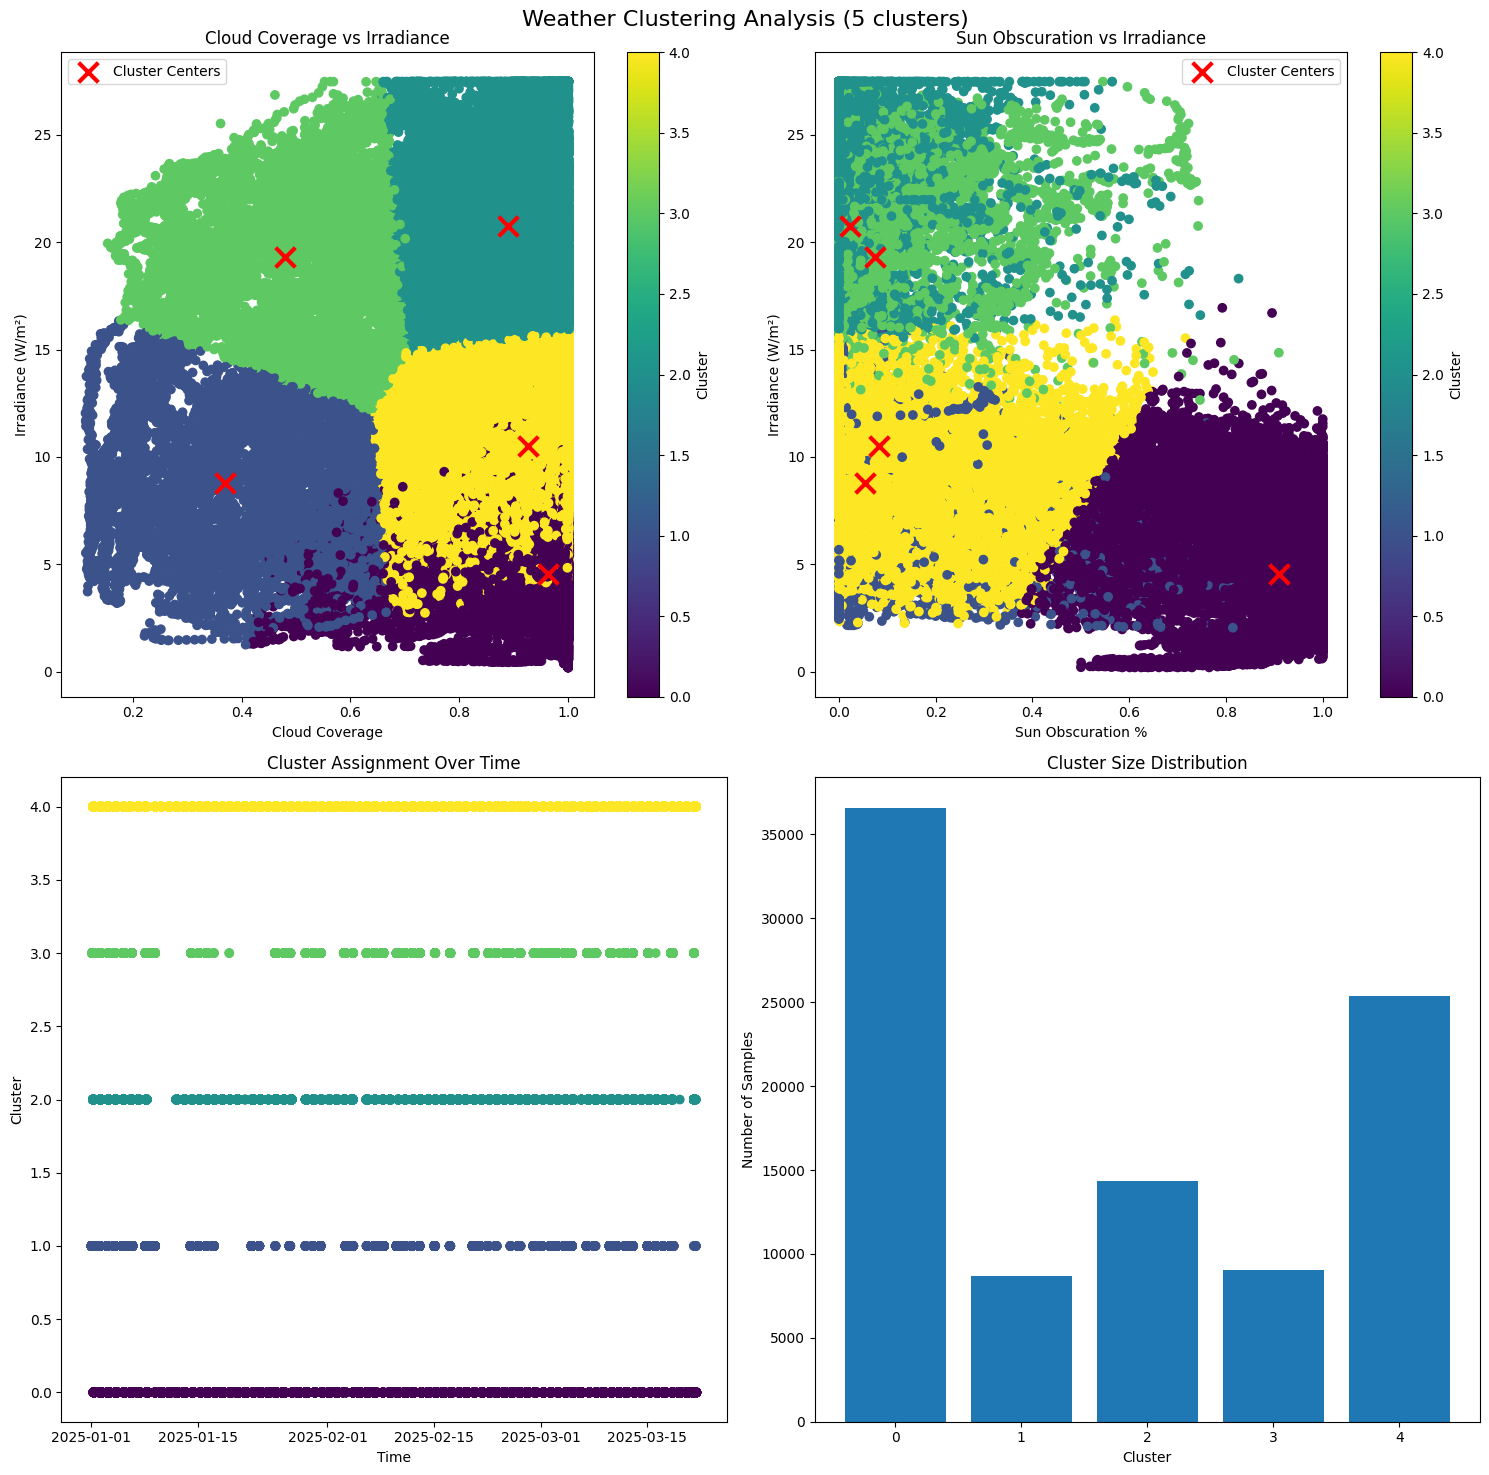


Cluster Statistics:

Sample counts per cluster:
cluster
0    36573
1     8657
2    14362
3     9019
4    25377
Name: count, dtype: int64

Feature means per cluster:
        cloud_coverage        irradiance        sun_obscuration_percentage  \
                  mean    std       mean    std                       mean   
cluster                                                                      
0                0.963  0.081      4.555  2.599                      0.909   
1                0.370  0.151      8.766  3.310                      0.055   
2                0.889  0.096     20.752  3.402                      0.023   
3                0.479  0.137     19.296  3.276                      0.075   
4                0.927  0.094     10.516  2.854                      0.082   

               cluster  
           std    size  
cluster                 
0        0.119   36573  
1        0.159    8657  
2        0.070   14362  
3        0.130    9019  
4        0.138   25377  

Testing 

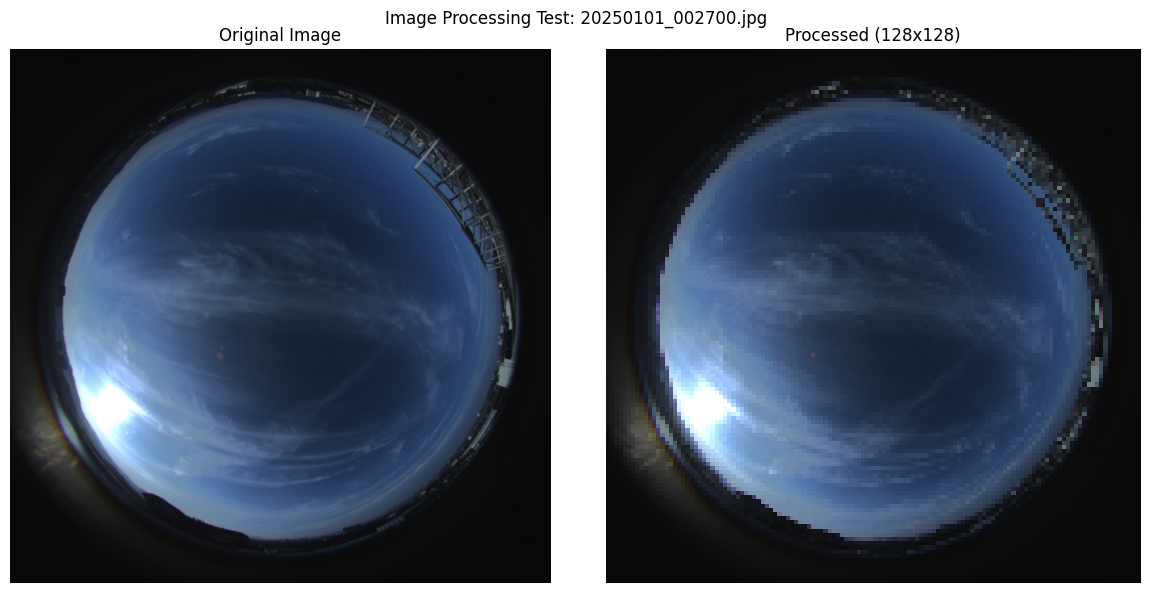


Processing image 2/5: 20250101_002730.jpg
Loading image...
Original size: (1158, 1172, 3)
Resizing to 128x128...
Resized shape: (128, 128, 3)
Converting to RGB...


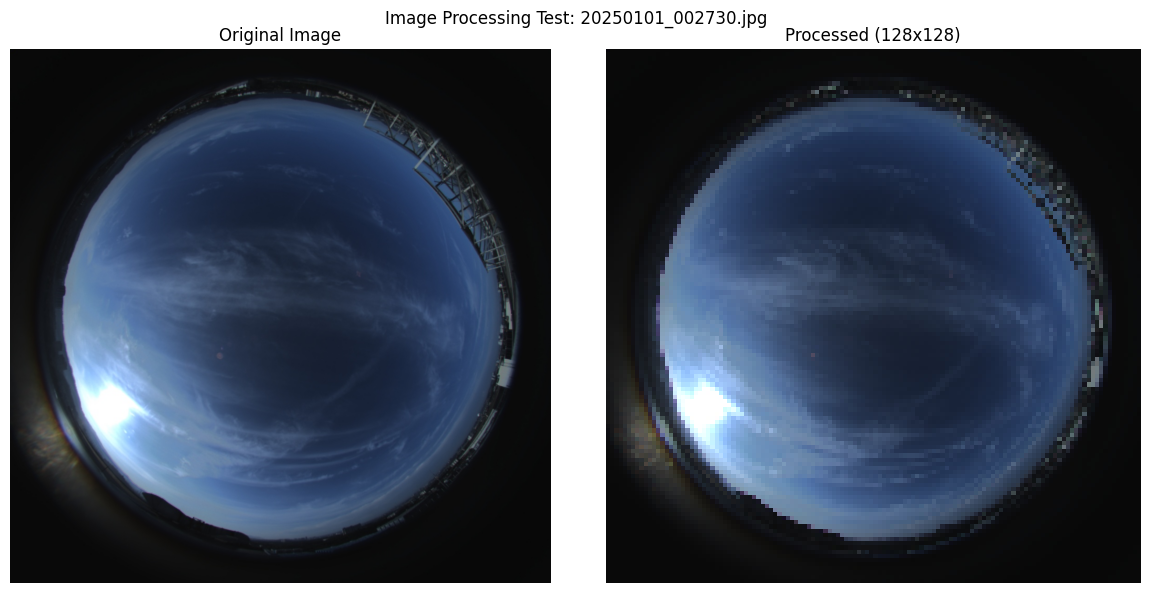


Processing image 3/5: 20250101_002800.jpg
Loading image...
Original size: (1158, 1172, 3)
Resizing to 128x128...
Resized shape: (128, 128, 3)
Converting to RGB...


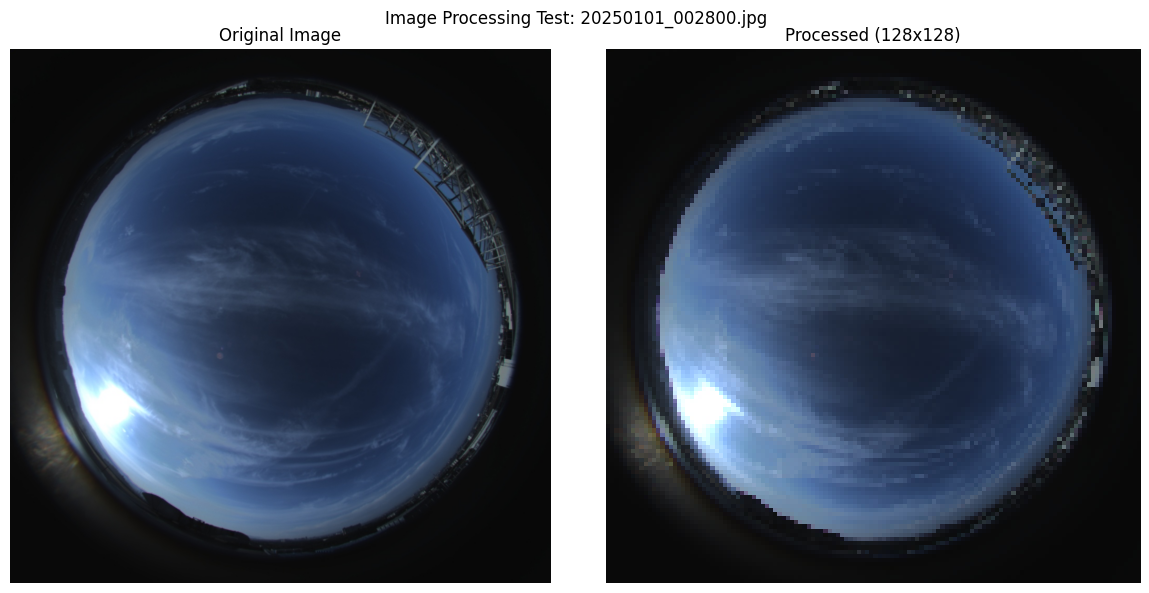


Processing image 4/5: 20250101_002830.jpg
Loading image...
Original size: (1158, 1172, 3)
Resizing to 128x128...
Resized shape: (128, 128, 3)
Converting to RGB...


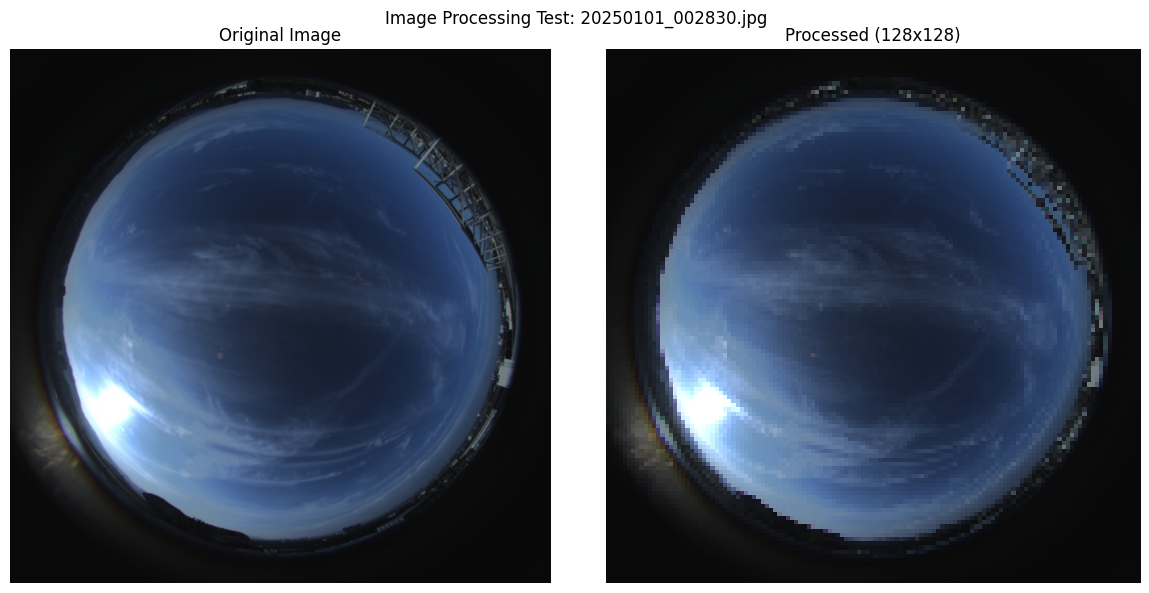


Processing image 5/5: 20250101_002900.jpg
Loading image...
Original size: (1158, 1172, 3)
Resizing to 128x128...
Resized shape: (128, 128, 3)
Converting to RGB...


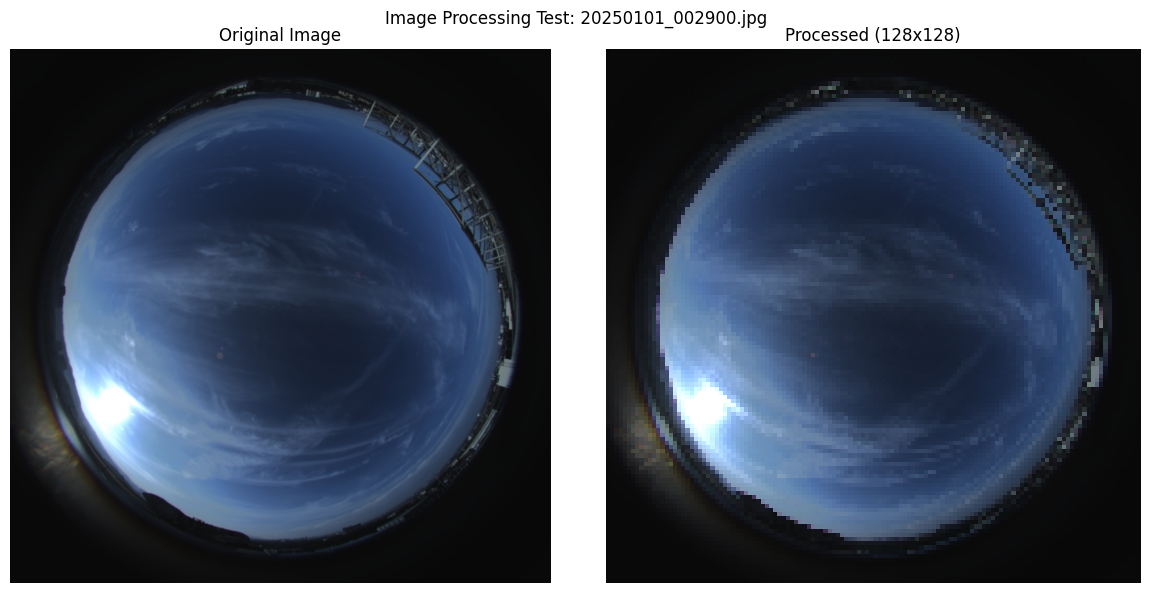

In [12]:
# Run clustering-only test first
print("Testing clustering without image processing...")
df, kmeans = test_clustering_only(json_dir, n_clusters=5)

# Then test image processing with 5 samples
print("\nTesting image processing with 5 samples...")
processed_images = test_image_processing(base_dir, sample_size=5, image_size=128)

In [13]:
def organize_images_by_cluster(df, base_dir, output_dir):
    """
    Organize images into folders based on their cluster assignments.
    
    Args:
        df: DataFrame containing clustering results and image paths
        base_dir: Base directory containing the original images
        output_dir: Directory where cluster folders will be created
    """
    import shutil
    
    print("Organizing images into cluster folders...")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Keep track of statistics
    stats = {
        'total_images': 0,
        'copied_images': 0,
        'skipped_images': 0,
        'clusters': {}
    }
    
    # Process each unique cluster
    for cluster in df['cluster'].unique():
        # Create cluster directory
        cluster_dir = os.path.join(output_dir, f'cluster_{cluster}')
        os.makedirs(cluster_dir, exist_ok=True)
        stats['clusters'][cluster] = 0
        
        # Get all images for this cluster
        cluster_data = df[df['cluster'] == cluster]
        
        print(f"\nProcessing Cluster {cluster}...")
        print(f"Found {len(cluster_data)} images in this cluster")
        
        # Copy images to cluster directory
        for idx, row in cluster_data.iterrows():
            stats['total_images'] += 1
            
            # Get timestamp from the row
            timestamp = row['timestamp']
            
            # Find corresponding image file
            image_files = glob.glob(os.path.join(base_dir, f"{timestamp}*.jpg"))
            
            if image_files:
                # Use the first matching image file
                src_path = image_files[0]
                # Create destination path with same filename
                dst_path = os.path.join(cluster_dir, os.path.basename(src_path))
                
                try:
                    # Copy the image file
                    shutil.copy2(src_path, dst_path)
                    stats['copied_images'] += 1
                    stats['clusters'][cluster] += 1
                except Exception as e:
                    print(f"Error copying {src_path}: {e}")
                    stats['skipped_images'] += 1
            else:
                stats['skipped_images'] += 1
        
        print(f"Copied {stats['clusters'][cluster]} images to cluster_{cluster}")
    
    # Print final statistics
    print("\nImage Organization Summary:")
    print("=" * 50)
    print(f"Total images processed: {stats['total_images']}")
    print(f"Successfully copied: {stats['copied_images']}")
    print(f"Skipped images: {stats['skipped_images']}")
    print("\nImages per cluster:")
    for cluster, count in stats['clusters'].items():
        print(f"Cluster {cluster}: {count} images")

# Create a directory for clustered images
clustered_images_dir = os.path.join(base_dir, "clustered_images")

# Organize images based on clustering results
print("Organizing images into cluster folders...")
organize_images_by_cluster(df, base_dir, clustered_images_dir)

Organizing images into cluster folders...
Organizing images into cluster folders...

Processing Cluster 1...
Found 8657 images in this cluster
Copied 8657 images to cluster_1

Processing Cluster 3...
Found 9019 images in this cluster
Copied 9019 images to cluster_3

Processing Cluster 2...
Found 14362 images in this cluster
Copied 14362 images to cluster_2

Processing Cluster 4...
Found 25377 images in this cluster
Copied 25377 images to cluster_4

Processing Cluster 0...
Found 36573 images in this cluster
Copied 36573 images to cluster_0

Image Organization Summary:
Total images processed: 93988
Successfully copied: 93988
Skipped images: 0

Images per cluster:
Cluster 1: 8657 images
Cluster 3: 9019 images
Cluster 2: 14362 images
Cluster 4: 25377 images
Cluster 0: 36573 images
